In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import clone
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
mnist = fetch_openml("mnist_784", version=1)
print(mnist.keys())

X, y = mnist["data"], mnist["target"]
y = y=="1"
y.shape

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


(70000,)

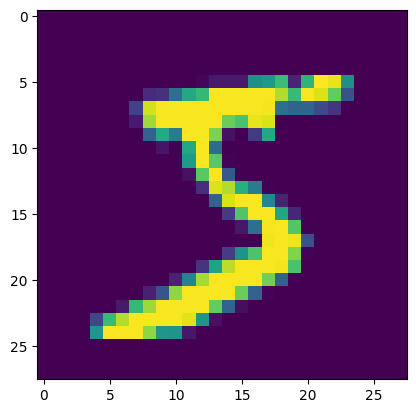

In [3]:
plt.imshow(X.iloc[0].values.reshape(28,28))

## Stratified Split

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    strat_train_set = X.loc[train_index]
    strat_train_labels = y.loc[train_index]
    strat_test_set = X.loc[test_index]
    strat_test_labels = y.loc[test_index]

## Stratified Cross-Validation

In [5]:
classifier_model = SGDClassifier(random_state=42)
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(strat_train_set, strat_train_labels):
    train_set = strat_train_set.iloc[train_index]
    train_labels = strat_train_labels.iloc[train_index]
    test_set = strat_train_set.iloc[test_index]
    test_labels = strat_train_labels.iloc[test_index]

    model_clone = clone(classifier_model)
    model_clone.fit(train_set, train_labels)
    predictions = model_clone.predict(test_set)
    accuracy = sum(predictions==test_labels)/(len(test_labels))
    print(accuracy)


0.982268173782611
0.9885894894734023
0.9831243972999035


In [6]:
print(sum(y==True)/len(y))

0.11252857142857142


In [7]:
model_predictions = cross_val_predict(classifier_model, strat_train_set, strat_train_labels, cv=3)

In [8]:
confusion_matrix(strat_train_labels, model_predictions)

array([[49202,   496],
       [  363,  5939]])

In [9]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(strat_train_labels, model_predictions))

print(recall_score(strat_train_labels, model_predictions))

0.922921522921523
0.9423992383370359


In [10]:
classifier_model.fit(strat_train_set, strat_train_labels)

SGDClassifier(random_state=42)

In [11]:
strat_train_set.iloc[0]

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 18201, Length: 784, dtype: int64

In [12]:
for i in range(5):
    score = classifier_model.decision_function([strat_train_set.iloc[i]])
    pred = classifier_model.predict([strat_train_set.iloc[i]])
    print(score, pred)

[-46809.95805696] [False]
[6553.70585533] [ True]
[-13187.68186442] [False]
[4910.45286989] [ True]
[-42549.63111972] [False]


/home/cmodi/cmodi/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/cmodi/cmodi/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/cmodi/cmodi/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/cmodi/cmodi/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/cmodi/cmodi/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/cmodi/cmodi/venv/lib/python3.10/site-packages/sklearn/

In [98]:
scores = cross_val_predict(classifier_model, strat_train_set, strat_train_labels, cv=3, method="decision_function")

In [99]:
y_scores

array([-58922.38126896,  21617.02592254,  -5367.17533538, ...,
       -49445.75973879, -85159.94801118, -30432.29395474])

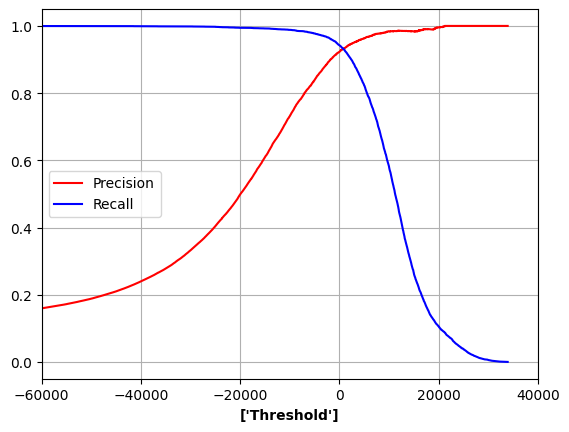

In [100]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(strat_train_labels, scores)

plt.plot(thresholds, precision[:-1], "r-", label="Precision")
plt.plot(thresholds, recall[:-1], "b-", label="Recall")
plt.grid()
plt.legend(loc ="center left")
plt.xlabel(["Threshold"], fontweight='bold')
plt.xlim([-60000, 40000])
plt.show()

In [101]:
preferred_threshold = 0
for i in range(len(thresholds)):
    if recall[i] >= .95 and precision[i] >= 0.9:
        preferred_threshold = thresholds[i]
        break

#preferred_threshold = thresholds[np.argmax(recall >= 1)]
preferred_threshold

-1790.67257359577

In [91]:
new_pred = (y_scores >= preferred_threshold)
y_precision = precision_score(strat_train_labels, new_pred)
y_recall = recall_score(strat_train_labels, new_pred)
y_precision, y_recall


(0.9000297088532383, 0.9614408124404951)

In [19]:
from sklearn.metrics import roc_curve

In [103]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(strat_train_labels, scores)

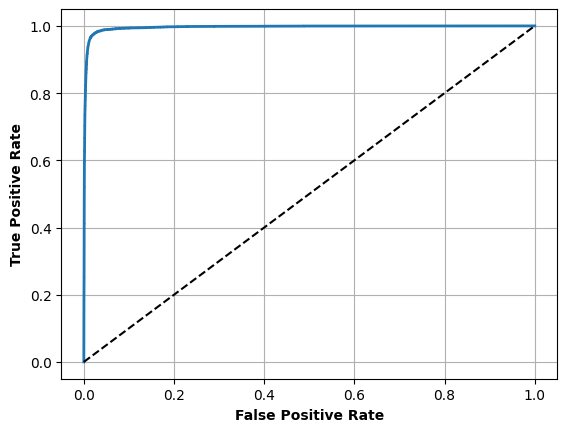

In [108]:
plt.plot(false_pos_rate, true_pos_rate, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate", fontweight="bold")
plt.ylabel("True Positive Rate", fontweight="bold")
plt.grid()
plt.show()

In [109]:
from sklearn.metrics import roc_auc_score
roc_auc_score(strat_train_labels, scores)

0.9957041674206655

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, strat_train_set, strat_train_labels, cv=3,
method="predict_proba")

In [58]:
forest_scores = y_probas_forest[:,1]
#forest_scores = (y_scores_forest >= preferred_threshold)
#forest_y_precision = precision_score(strat_train_labels, forest_scores)
#forest_y_recall = recall_score(strat_train_labels, forest_scores)
#forest_y_precision, forest_y_recall

In [59]:
fpr_forest, tpr_forest, thresholds = roc_curve(strat_train_labels, forest_scores)

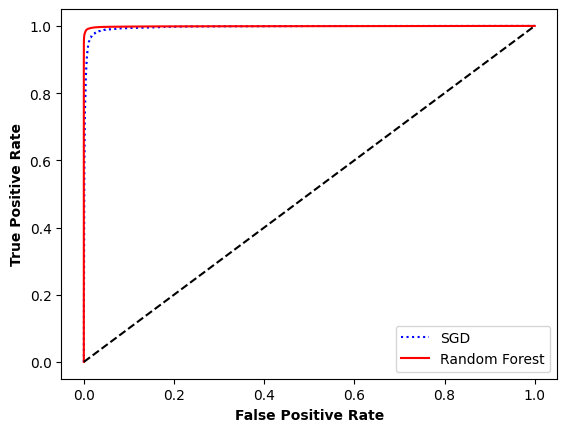

In [63]:
plt.plot(false_pos_rate, true_pos_rate, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, "r-", label="Random Forest")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate", fontweight="bold")
plt.ylabel("True Positive Rate", fontweight="bold")
plt.legend(loc="lower right")
plt.show()